In [1]:
from pathlib import Path

import astropy.units as u
from astropy.coordinates import SkyCoord
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service

np.random.seed(0)


def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.
    From Rubin DP0.2 Tutorial notebooks by the Community Science Team.
    """
    import gc

    plt.show()
    
    # so that we can pass either a fig or a (fig, ax) tuple.
    if isinstance(fig, tuple):
        fig = fig[0]
    
    # Get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # Clear the figure
    plt.close(fig)  # Close the figure
    gc.collect()    # Call the garbage collector



def table_summary(service, table_name: str):
    s = ""
    description = service.search(
        "SELECT description "
        "FROM tap_schema.tables "
        "WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs'" 
        f"AND table_name = 'dp02_dc2_catalogs.{table_name}'"
    ).to_table().to_pandas().iloc[0]["description"]
    s += f"{table_name}: {description}\n\n"
    for i, row in service.search(
            "SELECT column_name, datatype, description, unit "
            "FROM tap_schema.columns "
            f"WHERE table_name = 'dp02_dc2_catalogs.{table_name}'"
        ).to_table().to_pandas().iterrows():
        s += f"{row.column_name}:  {row.description} ({row.datatype})\n"
    return s


service = get_tap_service("tap")

# Counter-part simulation


## Redshift, magnitudes

We try to simulate a distribution of sourcecs similiar to the one of Kann et al., 2011.

<img src="https://s3.amazonaws.com/aasie/images/0004-637X/734/2/96/apj387210f16_hr.jpg"/>

The method is very rough and will show its limitation for large samples. However, for a small sample, it should be fine-ish. We may improve it later.

In [2]:
def sample_z_mag(n: int):
    dist_binom = stats.bernoulli(p=0.2)
    dist_zt1 = stats.uniform(scale = 1, loc=0.08)
    dist_mt1 = stats.uniform(scale = 9, loc=-21)
    dist_zt2 = stats.uniform(scale = 8, loc=0.3)
    dist_mt2 = stats.uniform(scale = 7, loc=-26)

    samples_binom = dist_binom.rvs(n)
    nt1 = len(samples_binom[samples_binom == 1])
    nt2 = n - nt1
    samples_zt1 = dist_zt1.rvs(nt1)
    samples_mt1 = dist_mt1.rvs(nt1)
    samples_zt2 = dist_zt2.rvs(nt2)
    samples_mt2 = dist_mt2.rvs(nt2)
    out =  np.hstack((
        np.vstack((samples_zt1, samples_mt1, np.ones(nt1))),
        np.vstack((samples_zt2, samples_mt2, np.zeros(nt2))),
    )).T
    return out

We have to transform magnitudes, absolute to apparent. To achieve this we compute the luminosity distance according:
$$ D_L = 10^{\frac{(m - M)}{5}+1} $$
The cosmology we take into account is a Flat Lambda CDM with $H_0=70$ and $\Omega_m = 0.3$.

In [3]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

def zm2appmag(z, abs_mag):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    luminosity_distance = cosmo.luminosity_distance(z).to(u.pc).value
    return float(abs_mag + 5 * np.log10(luminosity_distance) - 5)

Finally we put everything together into a dataframe for the synthetic sources.

In [4]:
def generate_source_table(n: int):
    ss = sample_z_mag(n)
    appmag = np.array([*map(lambda x: zm2appmag(x[0], x[1]), ss)])
    return pd.DataFrame({
        "redshift": ss[:, 0],
        "m": appmag,
        "M": ss[:, 1],
        "pop": [*map(lambda x: -x + 2, ss[:, 2])]
    })

afterglow_df = generate_source_table(80)

Let's visualize the source we generated.

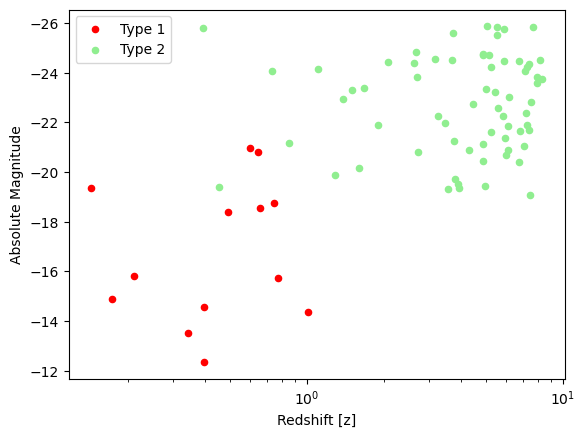

In [5]:
mask = afterglow_df["pop"] == 1
plt.scatter(afterglow_df[mask]["redshift"], afterglow_df[mask]["M"], c="red", s = 20, label="Type 1")
plt.scatter(afterglow_df[~mask]["redshift"], afterglow_df[~mask]["M"], c="lightgreen", s = 20, label="Type 2")
plt.gca().invert_yaxis()
plt.xscale("log")
plt.ylabel("Absolute Magnitude")
plt.xlabel("Redshift [z]")
plt.legend()
plt.show()

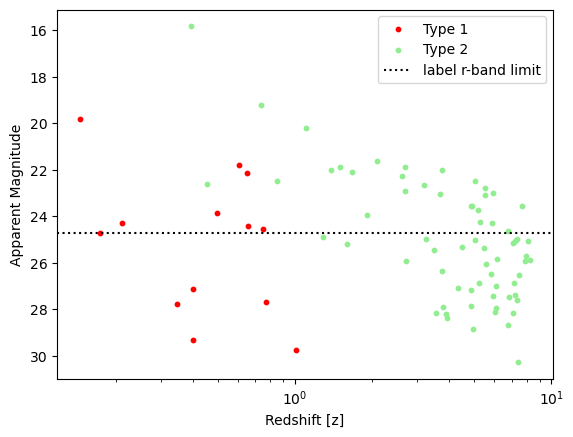

In [6]:
mask = afterglow_df["pop"] == 1
plt.scatter(afterglow_df[mask]["redshift"], afterglow_df[mask]["m"], c="red", s = 10, label="Type 1")
plt.scatter(afterglow_df[~mask]["redshift"], afterglow_df[~mask]["m"], c="lightgreen", s = 10, label="Type 2")
plt.axhline(24.7, label="label r-band limit", linestyle=":", color="k")
plt.gca().invert_yaxis()
plt.xscale("log")
plt.ylabel("Apparent Magnitude")
plt.xlabel("Redshift [z]")
plt.legend()
plt.show()

We cut sources under magnitude 24.7, the LSST r-band, single exposure magnitude limit and describe the reduced dataframe content.

In [7]:
afterglow_df[afterglow_df["m"] < 24.7].describe()

,redshift,m,M,pop
count,34.000000,34.000000,34.000000,34.000000
mean,2.840202,22.537848,-23.152877,1.794118
std,2.241772,1.759294,2.656425,0.410426
min,0.144147,15.823521,-25.870347,1.000000
25%,0.737881,22.002291,-24.732218,2.000000
50%,2.352637,22.700756,-24.313801,2.000000
75%,5.000902,23.684568,-21.363814,2.000000
max,7.655861,24.621743,-15.814584,2.000000


## Hosts and coordinates

We asssociate, whenever possible, a random simulated source to each transient. For transients at high z, a suitable host may not be present in the DC0.2 truth catalog. When this happen, we do not assign a counterparts to the source, simulating a scenario in which the host is too far to be resolved.

In [8]:
afterglow_df = afterglow_df[afterglow_df["m"] < 24.7].reset_index(drop=True)
afterglow_df[:10]

,redshift,m,M,pop
0,0.494263,23.835787,-18.395345,1.0
1,0.144147,19.820295,-19.351278,1.0
2,0.646601,22.117489,-20.819032,1.0
3,0.603248,21.795481,-20.957741,1.0
4,0.655946,24.404574,-18.569928,1.0
5,0.747410,24.559995,-18.761222,1.0
6,0.211798,24.280997,-15.814584,1.0
7,5.036335,22.492464,-25.870347,2.0
8,2.084653,21.634779,-24.432527,2.0
9,5.895834,22.985564,-25.777127,2.0


In [9]:
ramin, ramax = 55, 70
decmin, decmax = -42.5, -30.0


def verbose(f):
    COUNTER = [0]

    def helper(*args, **kwargs):
        print(f"on iteration {COUNTER[0]}..")
        r =  f(*args, **kwargs)
        print(f"  found a host with ra={r['ts_ra']:.2f}, dec={r['ts_dec']:.2f}, z={r['ts_redshift']:.2f}.")
        COUNTER[0] += 1
        return r
    return helper
    
    
def find_random_host(redshift, tol=0.1, ramin=55, ramax=70, decmin=-42, decmax=-30, max_attempts=5):
    random_ra = float(stats.uniform(scale=ramax-ramin, loc=ramin).rvs(1)[0])
    random_dec = float(stats.uniform(scale=decmax-decmin, loc=decmin).rvs(1)[0])
    
    attempts = 0
    candidates = pd.DataFrame({})
    while len(candidates) == 0:
        # query sources in a random small cone region of the simulation domain
        query = (
            "SELECT ts.ra AS ts_ra, "
            "ts.dec AS ts_dec, "
            "ts.mag_r AS ts_mag_r, "
            "ts.id_truth_type AS ts_idtruth, "
            "ts.redshift AS ts_redshift, "
            "ts.flux_r AS ts_flux_r "
            "FROM dp02_dc2_catalogs.TruthSummary AS ts "
            f"WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', {random_ra:.2f}, {random_dec:.2f}, 0.1)) = 1 "
            # we seek sources with redshift "close" to the simulated value
            f"AND ts.redshift >= {redshift - redshift * tol} "
            f"AND ts.redshift < {redshift + redshift * tol} "
            "AND ts.truth_type = 1 " # galaxies
        )
        
        job = service.submit_job(query)
        job.run()
        job.wait(phases=['COMPLETED', 'ERROR'])
        candidates = job.fetch_result().to_table().to_pandas()
        if attempts > max_attempts:
            # if we exceed max attempts we retun no information on the host
            print(f"  ! Could not find a suitable host at z={redshift:.2f}. Returning made up values.")
            return {
                'ts_ra': random_ra,
                'ts_dec': random_dec,
                'ts_mag_r': None,
                'ts_idtruth': None,
                'ts_redshift': redshift,
                'ts_flux_r': None,
            }
        # if we don't find a counterpart we try again up a max numberr off times 
        attempts += 1
    return candidates.sample(1).to_dict("records")[0]


_fp = Path("data/06_sourceCatalogSim/hosts.csv")
if _fp.is_file():
    hosts = pd.read_csv(_fp)
else:
    pd.DataFrame(hosts).to_csv(_fp, index=False)

Let's concatenate the dataframe together.

In [10]:
events_df = pd.concat((afterglow_df, pd.DataFrame(hosts)), axis= 1).reset_index(drop=True)
events_df

,redshift,m,M,pop,ts_ra,ts_dec,ts_mag_r,ts_idtruth,ts_redshift,ts_flux_r
0,0.494263,23.835787,-18.395345,1.0,68.036669,-40.555018,28.544201,9812960928_1,0.517230,13.878000
1,0.144147,19.820295,-19.351278,1.0,58.451572,-32.906114,25.807301,5000026223_1,0.157696,172.608994
2,0.646601,22.117489,-20.819032,1.0,55.452444,-37.742541,28.719500,7813193635_1,0.597980,11.808800
3,0.603248,21.795481,-20.957741,1.0,67.610699,-38.583603,27.466700,9000586006_1,0.570496,37.438099
4,0.655946,24.404574,-18.569928,1.0,56.256146,-39.846415,24.171101,9563515687_1,0.704722,779.044983
5,0.747410,24.559995,-18.761222,1.0,66.077289,-36.718481,28.135500,7063773530_1,0.747544,20.220100
6,0.211798,24.280997,-15.814584,1.0,61.433644,-34.261683,26.470501,6000054537_1,0.230425,93.714600
7,5.036335,22.492464,-25.870347,2.0,64.241827,-33.204443,NaN,NaN,5.036335,NaN
8,2.084653,21.634779,-24.432527,2.0,68.277022,-40.993586,28.549999,10633785949_1,1.919110,13.804100
9,5.895834,22.985564,-25.777127,2.0,62.662949,-36.956756,NaN,NaN,5.895834,NaN


Having redshifts from the truth table, we drop the simulated z column.

In [11]:
events_df = events_df.drop(columns = ["redshift"])

# How the hosts looks like 

In [12]:
import numpy as np

In [13]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import astropy.visualization as vis

def get_limits(img_data: np.array, scale: float | None = None) -> dict:
    zscale = vis.ZScaleInterval()
    if scale is None:
        return {"vmin": (_l := zscale.get_limits(img_data))[0], "vmax": _l[1]}
    elif 0. < scale < 100.:
        return {"vmin": np.percentile(img_data, scale), "vmax": np.percentile(img_data, 100 - scale)}
    else:
        raise ValueError("Paramter `scale` is a percentile and should be comprised between 0 and 100.")


def plot_host(img, ra, dec, scale:float | None = None):
    img_wcs = WCS(img.getWcs().getFitsMetadata())
    img_data = img.getImage().array
    coord_galhost = SkyCoord(
        ra = ra * u.degree, 
        dec = dec * u.degree,
    )
    bbox_extent = (img.getBBox().beginX, img.getBBox().endX, img.getBBox().beginY, img.getBBox().endY)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    plt.subplot(projection=img_wcs)
    plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'r*', markerfacecolor="None", ms=20, label="Host galaxy")
    plt.imshow(img_data, cmap='gray', extent=bbox_extent, **get_limits(img_data, scale))
    plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
    plt.grid(color='grey', ls='solid')
    plt.legend(loc="lower left")
    return fig, ax


def plot_zoom(img, ra, dec, side_px=250, scale:float | None = None):
    wcs = WCS(img.getWcs().getFitsMetadata())
    coord_center = SkyCoord(
        ra = ra * u.deg,
        dec = dec * u.deg,
        frame='icrs'
    )
    img_data = img.getImage().array
    bbox_extent = (img.getBBox().beginX, img.getBBox().endX, img.getBBox().beginY, img.getBBox().endY)
    center_x_pixel, center_y_pixel = wcs.world_to_pixel(coord_center)
    half_side_px = side_px // 2 

    fig, ax = plt.subplots(1, figsize=(10, 10))
    plt.imshow(img_data, cmap='gray', extent=bbox_extent, origin="lower", **get_limits(img_data, scale))
    ax.plot(*(center_x_pixel, center_y_pixel), 'k+', markerfacecolor="None", ms=40)
    ax.set_xlim(center_x_pixel - half_side_px , center_x_pixel + half_side_px)
    ax.set_ylim(center_y_pixel - half_side_px, center_y_pixel + half_side_px)
    return fig, ax

In [14]:
from lsst.daf.butler import Butler
import lsst.geom as geom

config = 'dp02' 
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

def get_tract_and_patch(butler, ra, dec):
    skymap = butler.get('skyMap')
    target = geom.SpherePoint(ra * geom.degrees, dec * geom.degrees)
    tract = (_tract := skymap.findTract(target)).tract_id
    patch = _tract.findPatch(target).getSequentialIndex()
    return tract, patch

def get_anchor_image(butler, ra, dec, band):
    tract, patch = get_tract_and_patch(butler, ra, dec)
    return butler.get(
        'deepCoadd', 
        dataId={
            "tract": tract,
            "patch": patch,
            "band": band,
    })

# here we select thesource
SORTBY, RANK = "ts_flux_r", 1

host_ra, host_dec = [*events_df.sort_values(SORTBY, ascending=False)[["ts_ra", "ts_dec"]].iloc[RANK]]
band = "r"
tract, patch = get_tract_and_patch(butler, host_ra, host_dec)
print(f"Looking for coadd at tract = {tract}, patch = {patch} in band {band}")
coadd = get_anchor_image(butler, host_ra, host_dec, "r")

Looking for coadd at tract = 4433, patch = 11 in band r


The second host with highest flux is already difficult to distinguish from background!

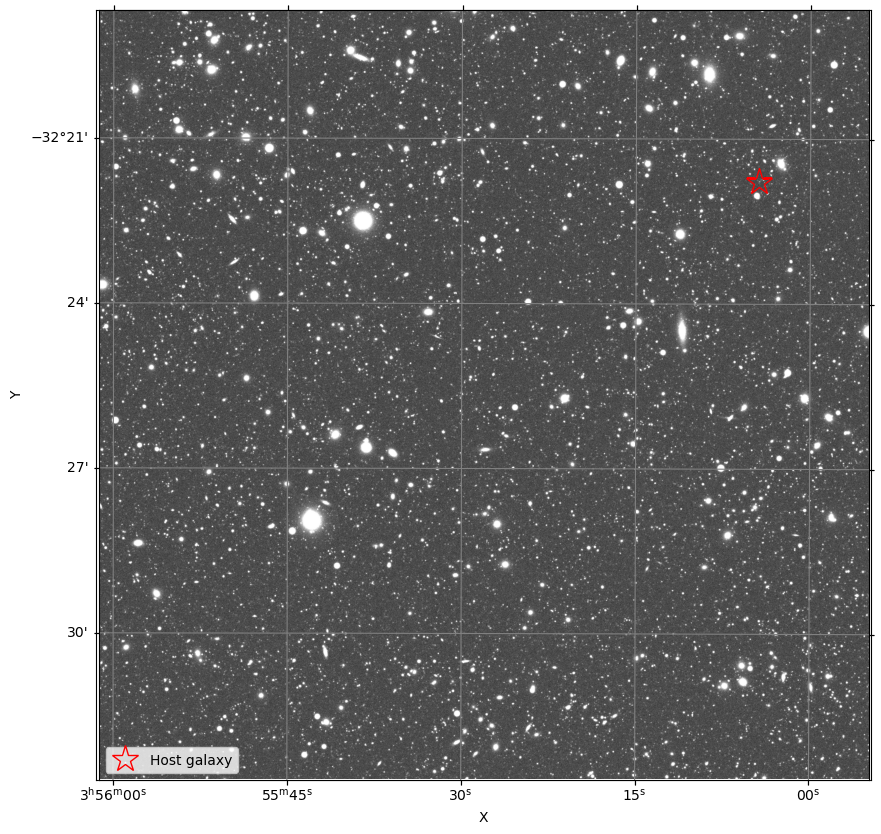

In [15]:
remove_figure(plot_host(coadd, host_ra, host_dec))

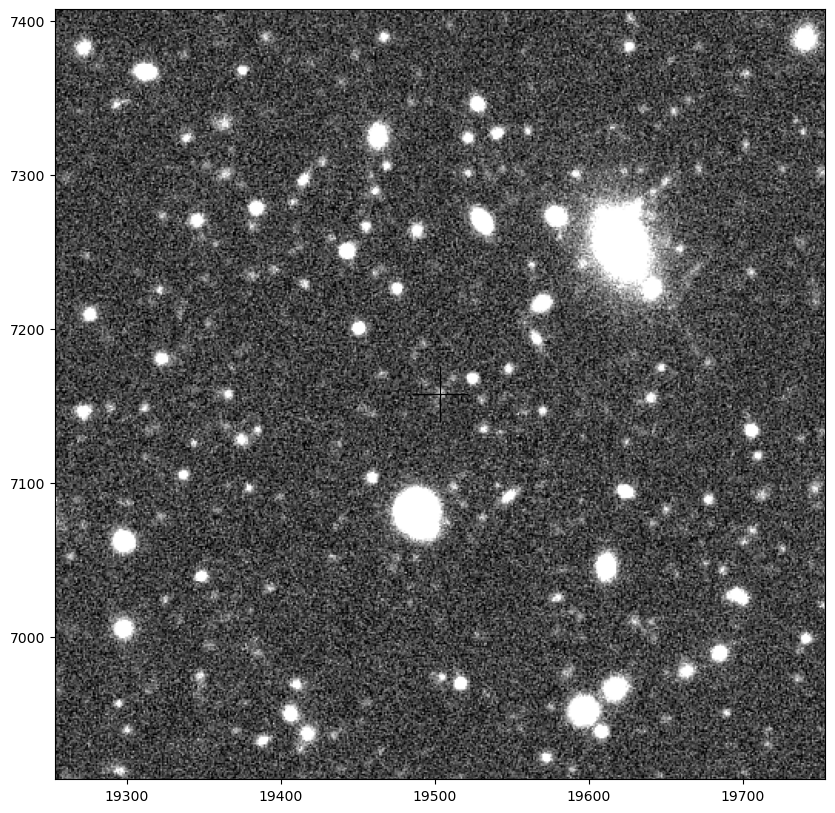

In [16]:
remove_figure(plot_zoom(coadd, host_ra, host_dec, side_px = 500, scale=2))

# Transient off-axis distance

Now that we have determined the host coordinates, we shall simulate the actual transient position relative to the host. To achieve these we will pick an angle randomly by sampling two numbers from -1 to +1, and using them as cosine and sine value. To choose a radius value we will sample from a distribution based on data from Table 4 of [Fong et al. 2022](https://iopscience.iop.org/article/10.3847/1538-4357/ac91d0/pdf).

In [17]:
offaxis_df = pd.read_csv("data/06_sourceCatalogSim/shortgrb_offaxis_table.txt")

In [18]:
offaxis_df

,GRB,z,afterglow,offset_arcsec,sigma_arcsec,offset_kpc,sigma_kpc,offset_re,sigma_re,reference
0,050509B,0.2248,X,15.100,3.400,55.19,12.430,2.59,0.58,1
1,050709,0.1607,X,1.350,0.020,3.76,0.056,2.00,0.03,1
2,050724A,0.2540,O,0.680,0.020,2.74,0.080,0.67,0.02,1
3,050813,0.7190,X,5.960,2.340,43.57,17.370,NaN,NaN,This work
4,051210,2.5800,X,3.560,2.000,29.08,16.340,5.65,3.17,1
...,...,...,...,...,...,...,...,...,...,...
78,210726A,0.3700,R,0.044,0.150,0.23,0.780,NaN,NaN,This work
79,210919A,0.2415,O,13.280,0.500,51.05,1.920,NaN,NaN,This work
80,211023B,0.8620,O,0.490,0.330,3.84,2.570,NaN,NaN,This work
81,211106A,NaN,R,0.097,0.036,0.79,0.290,0.49,0.18,"10, This work"


In [19]:
_df = offaxis_df
bins = [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8]
arcsec_means = []
for binstart, binend in zip(bins[:-1], bins[1:]):
    mask = (_df["z"] >= binstart) & (_df["z"] < binend)
    if len(_df[mask]["offset_arcsec"]) == 0:
        arcsec_means.append(0.)
    else:
        mean = np.mean(_df[mask]["offset_arcsec"])
        arcsec_means.append(float(mean))

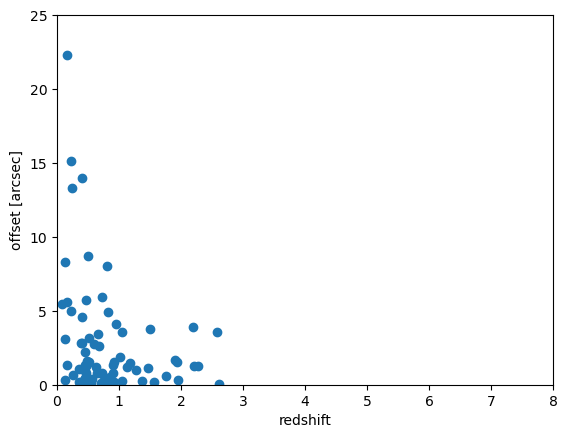

In [20]:
plt.scatter(offaxis_df["z"].astype(float), offaxis_df["offset_arcsec"].astype(float))
plt.xlabel("redshift")
plt.ylabel("offset [arcsec]")
plt.xlim(0., 8)
plt.ylim(0., 25)
plt.show()

In [21]:
from bisect import bisect

def sample_offaxis(bins, means, z):
    i = bisect(bins, z) - 1
    return stats.expon(scale=means[i]).rvs(1)[0]

angsep_arcsec = np.array([sample_offaxis(bins, arcsec_means, z) for z in events_df["ts_redshift"]])

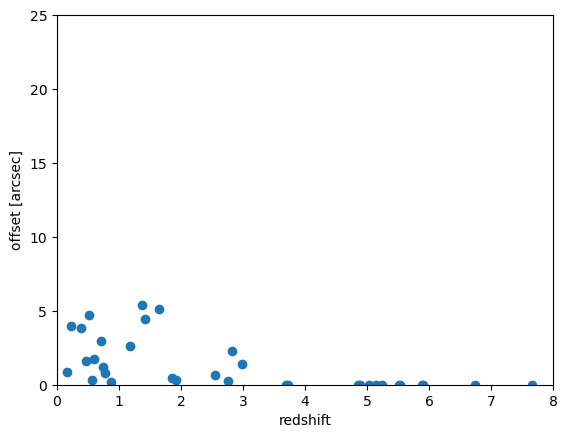

In [22]:
plt.scatter(events_df["ts_redshift"].astype(float), angsep_arcsec)
plt.xlabel("redshift")
plt.ylabel("offset [arcsec]")
plt.xlim(0., 8)
plt.ylim(0., 25)
plt.show()

We add the simulated separations to the dataframe

In [23]:
events_df["angsep_arcsec"] = angsep_arcsec 

Generate random angles.

In [24]:
events_df["theta_deg"] = stats.uniform(scale=360).rvs(len(events_df))

Based on these two values we generate the transient coordinate.

In [25]:
events_df.head()

,m,M,pop,ts_ra,ts_dec,ts_mag_r,ts_idtruth,ts_redshift,ts_flux_r,angsep_arcsec,theta_deg
0,23.835787,-18.395345,1.0,68.036669,-40.555018,28.544201,9812960928_1,0.517230,13.878000,4.684264,36.105819
1,19.820295,-19.351278,1.0,58.451572,-32.906114,25.807301,5000026223_1,0.157696,172.608994,0.853347,5.914667
2,22.117489,-20.819032,1.0,55.452444,-37.742541,28.719500,7813193635_1,0.597980,11.808800,1.711400,334.630554
3,21.795481,-20.957741,1.0,67.610699,-38.583603,27.466700,9000586006_1,0.570496,37.438099,0.332736,241.169957
4,24.404574,-18.569928,1.0,56.256146,-39.846415,24.171101,9563515687_1,0.704722,779.044983,2.964166,282.655048


In [26]:
coords = []
for ra, dec, sep, theta in events_df[["ts_ra", "ts_dec", "angsep_arcsec", "theta_deg"]].values:
    host_coord = SkyCoord(ra = ra * u. deg, dec = dec * u.deg)
    coords.append((lambda x: (float(x.ra.deg), float(x.dec.deg)))(host_coord.directional_offset_by(theta * u.deg, sep * u.arcsec)))

Let's add the afterglow coordinates..

In [27]:
ras, decs = zip(*coords)

events_df.insert(loc=0, column="dec", value=decs)
events_df.insert(loc=0, column="ra", value=ras)

And here's the final table.

In [28]:
events_df

,ra,dec,m,M,pop,ts_ra,ts_dec,ts_mag_r,ts_idtruth,ts_redshift,ts_flux_r,angsep_arcsec,theta_deg
0,68.037678,-40.553967,23.835787,-18.395345,1.0,68.036669,-40.555018,28.544201,9812960928_1,0.517230,13.878000,4.684264,36.105819
1,58.451601,-32.905878,19.820295,-19.351278,1.0,58.451572,-32.906114,25.807301,5000026223_1,0.157696,172.608994,0.853347,5.914667
2,55.452187,-37.742112,22.117489,-20.819032,1.0,55.452444,-37.742541,28.719500,7813193635_1,0.597980,11.808800,1.711400,334.630554
3,67.610596,-38.583648,21.795481,-20.957741,1.0,67.610699,-38.583603,27.466700,9000586006_1,0.570496,37.438099,0.332736,241.169957
4,56.255100,-39.846234,24.404574,-18.569928,1.0,56.256146,-39.846415,24.171101,9563515687_1,0.704722,779.044983,2.964166,282.655048
5,66.077691,-36.718546,24.559995,-18.761222,1.0,66.077289,-36.718481,28.135500,7063773530_1,0.747544,20.220100,1.184621,101.422838
6,61.432954,-34.262628,24.280997,-15.814584,1.0,61.433644,-34.261683,26.470501,6000054537_1,0.230425,93.714600,3.971152,211.107660
7,64.241827,-33.204443,22.492464,-25.870347,2.0,64.241827,-33.204443,NaN,NaN,5.036335,NaN,0.000000,23.023896
8,68.277033,-40.993674,21.634779,-24.432527,2.0,68.277022,-40.993586,28.549999,10633785949_1,1.919110,13.804100,0.317410,174.825935
9,62.662949,-36.956756,22.985564,-25.777127,2.0,62.662949,-36.956756,NaN,NaN,5.895834,NaN,0.000000,351.898250


Let's try to visualize host and afterglow location according simulation, for the most separated source.

In [29]:
# here we select thesource
SORTBY, RANK = "angsep_arcsec", 0

ra, dec, host_ra, host_dec = [*events_df.sort_values(SORTBY, ascending=False)[["ra", "dec", "ts_ra", "ts_dec"]].iloc[RANK]]
band = "r"
tract, patch = get_tract_and_patch(butler, host_ra, host_dec)
print(f"Looking for coadd at tract = {tract}, patch = {patch} in band {band}")
coadd = get_anchor_image(butler, host_ra, host_dec, "r")

Looking for coadd at tract = 3833, patch = 30 in band r


In [30]:
plot_zoom?

Signature: plot_zoom(img, ra, dec, side_px=250, scale: float | None = None)
Docstring: <no docstring>
File:      /tmp/ipykernel_19038/2134415170.py
Type:      function

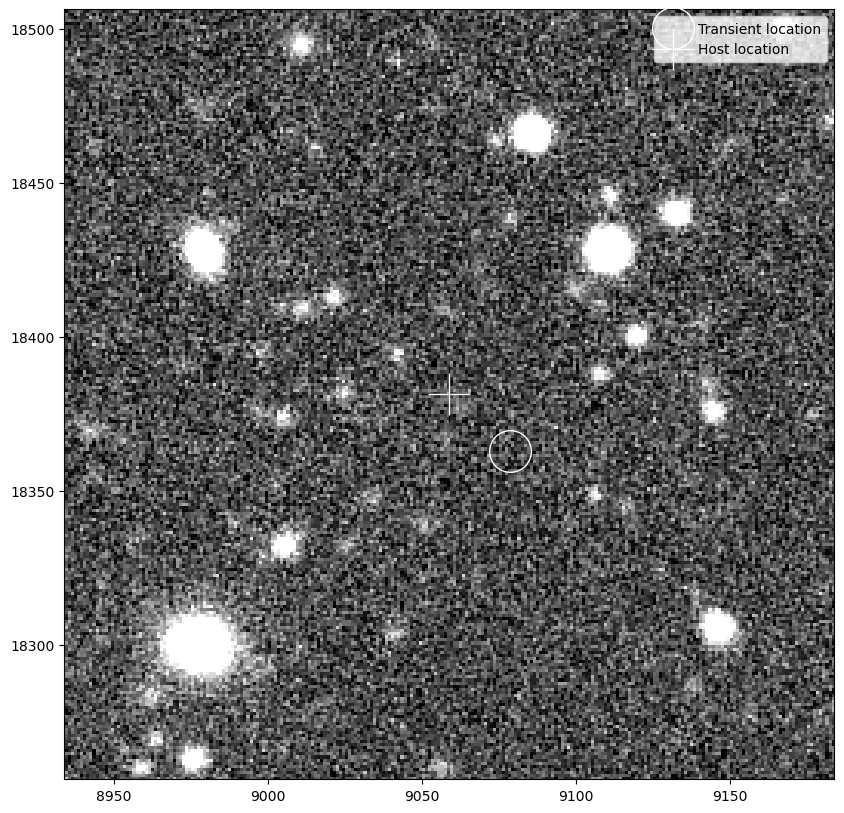

In [31]:
fig, ax = plot_zoom(coadd, host_ra, host_dec, scale=3)
coord_afterglow = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame='icrs')
coord_host = SkyCoord(ra = host_ra * u.deg, dec = host_dec * u.deg, frame='icrs')
wcs = WCS(coadd.getWcs().getFitsMetadata())
afterglow_x_pixel, afterglow_y_pixel = wcs.world_to_pixel(coord_afterglow)
host_x_pixel, host_y_pixel = wcs.world_to_pixel(coord_host)
ax.plot(*(afterglow_x_pixel, afterglow_y_pixel), 'ow', markerfacecolor="None", ms=30, lw=100, label="Transient location")
ax.plot(*(host_x_pixel, host_y_pixel), '+w', markerfacecolor="None", ms=30, lw=100, label="Host location")
plt.legend()
plt.show()

That's it! We save the results into a table we will use as input in the next notebook.

In [32]:
# events_df.to_csv("data/06_sourceCatalogSim/afterglow_host.csv", index=False)